# NLP with What'sApp messages : with sklearn, stochastic gradient descent

In [56]:
import pandas as pd
import numpy as np
import re 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [57]:
#load data
df = pd.read_csv("adara_corpus(all_tagged).csv", delimiter=";")

In [58]:
df.shape

(2961, 6)

### Data wrangling and initial cleaning of text

In [59]:
# rename all empty hashtag blocks
df['Hashtags'] = df['Hashtags'].fillna('blank')

In [60]:
df.head()

,CreateAt,Hashtags,Mensaje,UserId,Name_2,UserName
0,2019-05-13T13:00:10.000Z,#consulata_direccion,Soy de Córdoba capital no se de donde son ustedes,7kut6fgex3du7xt7s38h43shqw,adara,whatsapp
1,2019-05-13T13:00:12.000Z,#solicita_turno,Quiero un turno de la Campaña Gratuita,7kut6fgex3du7xt7s38h43shqw,adara,whatsapp
2,2019-05-13T16:36:13.000Z,#consulta_campaña,Gracias por comunicarse con Adara!\n\nLe infor...,ij6w4x8n9fbpxqxh79gj8474by,adara,adara
3,2019-05-20T15:35:29.000Z,#pendiente_respuesta,¡Buenas tardes! Nos comunicamos nuevamente par...,ij6w4x8n9fbpxqxh79gj8474by,adara,adara
4,2019-05-20T16:03:02.000Z,#cliente_potencial,Hola. si. me encantaria,7kut6fgex3du7xt7s38h43shqw,adara,whatsapp


In [61]:
#df = df.copy()[df["UserName"]=="whatsapp"]

In [62]:
# these are out classes (hashtags)
df.Hashtags.unique()

array(['#consulata_direccion', '#solicita_turno', '#consulta_campaña',
       '#pendiente_respuesta', '#cliente_potencial', '#turno_flebologia',
       'blank', '#agendar_turno', '#pedir_datos', '#datos_personales',
       '#dr_lamoratta', '#consulta_direccion', '#turno_cancelado',
       '#dra_elorza', '#turno_reprogramado', '#agradecido',
       '#turno_dermatologia', '#confirmado', '#dr_falcon',
       '#turno_confirmado', '#consulta_pago', '#turno_estetica',
       '#turno_facebook', '#saludo', '#dra_forni', '#no_brinda_datos',
       '#encuesta', '#direccion', '#otro_servicio', '#dr_morales',
       '#queja', '#lic_vazquez', '#recuerda_turno', '#turno_nutricion',
       '#dra_pozzi', '#negado', '#turno_confirmar', '#consulta_horario',
       '#lic_porchietto', '#solicita_info', '#consulta_confirmado',
       '#solicita_consulta'], dtype=object)

In [63]:
#simplify the data set. On the left the classes, the dependent variable (Y); and on the right the messages our independent variable (x)
df_simple = df.drop(['CreateAt', 'UserId', 'Name_2', 'UserName'], axis=1)
df_simple.head()

,Hashtags,Mensaje
0,#consulata_direccion,Soy de Córdoba capital no se de donde son ustedes
1,#solicita_turno,Quiero un turno de la Campaña Gratuita
2,#consulta_campaña,Gracias por comunicarse con Adara!\n\nLe infor...
3,#pendiente_respuesta,¡Buenas tardes! Nos comunicamos nuevamente par...
4,#cliente_potencial,Hola. si. me encantaria


### Prepare the Y variable: transform our classes into numbers

In [64]:
le = LabelEncoder()

In [65]:
df_simple.Hashtags = le.fit_transform(df_simple.Hashtags)
df_simple.head(10)

,Hashtags,Mensaje
0,4,Soy de Córdoba capital no se de donde son ustedes
1,31,Quiero un turno de la Campaña Gratuita
2,5,Gracias por comunicarse con Adara!\n\nLe infor...
3,25,¡Buenas tardes! Nos comunicamos nuevamente par...
4,2,Hola. si. me encantaria
5,38,Para Flebología tenemos disponibilidad de turn...
6,41,Por la tarde mejor
7,38,Contamos con disponibilidad de turno para los ...
8,0,\n¿Desea que agendemos alguno de estos turnos?\n
9,0,Bueno el 24/5 puedo ir


In [66]:
Y = df_simple['Hashtags'].values
Y

array([ 4, 31,  5, ..., 41, 41, 35])

### Prepare the X variable: clean the messages

In [67]:
#pre-processing (for later)
def clean_str(string):
    """
    Tokenization/string cleaning problematic characters for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]", " digit", string)
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string) 
    string = re.sub(r"[!]", "", string) 
    string = re.sub(r"[.]", "", string)
    string = re.sub(r"[–]", "", string)
    string = re.sub(r"[-]", "", string)
    string = re.sub(r"[*]", "", string)
    string = re.sub(r"[¿]", "", string)
    string = re.sub(r"[í]", "i", string)
    string = re.sub(r"[ó]", "o", string)
    string = re.sub(r"[//-:]", "", string)
    
    return string.strip().lower()

In [68]:
#
X = []
for i in range(df_simple.shape[0]):
    strng = str(df_simple.iloc[i][1])
    X.append(clean_str(strng))
X

['soy de cordoba capital no se de donde son ustedes',
 'quiero un turno de la campaña gratuita',
 'gracias por comunicarse con adarale informamos que nos encontramos en  av colon  digit digit digit digit  digitto piso  instituto medico damicsu consulta es para flebologia o estética?',
 '¡buenas tardes nos comunicamos nuevamente para saber si aún está interesadao en acceder a la consulta gratuita con nuestros profesionales de flebologia o estética médica si le interesa, podemos brindarle un turno ¡aguardamos su respuesta',
 'hola si me encantaria',
 'para flebologia tenemos disponibilidad de turnos por la mañana y por la tarde necesita algún horario en particular?',
 'por la tarde mejor',
 'contamos con disponibilidad de turno para los dias  digit digit digit digit digit digit digit digit digit digit digit digit dr morales  digit digit digit digit digit digit digit digit digit digit digit digit dr lamoratta',
 'desea que agendemos alguno de estos turnos?',
 'bueno el  digit digit digit 

### Train, test, split our data

In [69]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5)

### TF-IDF : send our messages to a vector space

In [70]:
# declare our tf-idf model vectorizer (contains tokenization)
tfidf = TfidfVectorizer(min_df=1)

In [71]:
tfidf = TfidfVectorizer(min_df=1)
# for training data use "fit_transform()"
x_train_tf = tfidf.fit_transform(x_train)
x_train_array = x_train_tf.toarray() # must be an dense array

In [72]:
#these are our words
#tfidf.get_feature_names()

In [73]:
# test data use "transform()"
x_test_tf = tfidf.transform(x_test)
x_test_array  = x_test_tf.toarray()

### The Stochastic Gradient Descent alogrithm: (loss ="log") means logistic regression 

In [74]:
sgd = SGDClassifier(loss="log", penalty="l2", max_iter=5)
sgd.fit(x_train_array, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [75]:
#predictions
pred_sgd = sgd.predict(x_test_array)

In [76]:
actual=np.array(y_test)
#actual

In [77]:
f1_score(actual,pred_sgd,average='micro')

0.6332958380202475

In [78]:
count=0
for i in range (len(pred_sgd)):
    if pred_sgd[i]==actual[i]:
        count=count+1
print("We have",count,"correct predictions out of",len(pred_sgd),".")
print("Total",(count/len(pred_sgd))*100,"accuracy using Stochastic Gradient Descent.")

We have 563 correct predictions out of 889 .
Total 63.32958380202475 accuracy using Stochastic Gradient Descent.


In [79]:
# preparing our results for a tabular visualization
messg = []
for msg in x_test:
    messg.append(msg)
predictions = []
for x in le.inverse_transform(pred_sgd):
    predictions.append(x)
original = []
for i in le.inverse_transform(y_test):
    original.append(i)
# this is the Original, hand labeled data
dataf = pd.DataFrame({'ORIGINAL_TYPE' : original,
                      'ML_PREDICT' : predictions,
                     'TEXT' : messg})
dataf

,ML_PREDICT,ORIGINAL_TYPE,TEXT
0,#agendar_turno,#turno_reprogramado,"si, solo quiero cambiarlo por un martes me pue..."
1,#datos_personales,#datos_personales,carla mariel bracamonte dni digit digit digit...
2,#cliente_potencial,#datos_personales,esos datos no se piden cuando ya estas en la c...
3,#confirmado,#confirmado,si
4,#agendar_turno,#agendar_turno,por la tarde por favot
5,blank,#consulta_direccion,piso
6,blank,#turno_confirmado,muchisimas gracias ahi estare sin falta
7,blank,blank,gracias por comunicarse con adarale informamos...
8,#agendar_turno,#agendar_turno,podria tomar un turno por la tarde
9,#agendar_turno,#turno_facebook,buenas tarde el miércoles tengo un turno ya lo...


# let's check out the probability

In [80]:
def predict(self):
    predicted = []
    prob = []
    mesauge = clean_str(self)
    mess = [mesauge]
    message = tfidf.transform(mess)
    messages = message.toarray()
    predicted = sgd.predict(messages)
    final = str(le.inverse_transform(predicted))            
    return final[2:-2] 

In [81]:
def prob(self):
    mesauge = clean_str(self)
    mess = [mesauge]
    message = tfidf.transform(mess)
    messages = message.toarray()
    global bigprob
    pred_prob = sgd.predict_proba(messages)
    bigprob = 0
    for line in pred_prob:
        for var in line:
            if bigprob < var:
                bigprob = var
            else: 
                continue
            
        return bigprob #,final, bigprob

In [82]:
predictions = []
message = []
probabilities = []
for i in x_test:
    predictions.append(predict(i))
    probabilities.append(prob(i))
    message.append(i)

In [83]:
dataf = pd.DataFrame({'ORIGINAL_MESS' : message,
                      'ML_PREDICT' : predictions, 
                     "PROBABILITY" : probabilities})
dataf = dataf[['PROBABILITY','ML_PREDICT', 'ORIGINAL_MESS']]
dataf.head(30)

,PROBABILITY,ML_PREDICT,ORIGINAL_MESS
0,0.387262,#agendar_turno,"si, solo quiero cambiarlo por un martes me pue..."
1,0.510012,#datos_personales,carla mariel bracamonte dni digit digit digit...
2,0.544338,#cliente_potencial,esos datos no se piden cuando ya estas en la c...
3,0.674379,#confirmado,si
4,0.794385,#agendar_turno,por la tarde por favot
5,0.511825,blank,piso
6,0.208211,blank,muchisimas gracias ahi estare sin falta
7,0.558654,blank,gracias por comunicarse con adarale informamos...
8,0.551422,#agendar_turno,podria tomar un turno por la tarde
9,0.372420,#agendar_turno,buenas tarde el miércoles tengo un turno ya lo...


## VIZ

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [85]:
bin_edges = 20
bin_edges2 = 40

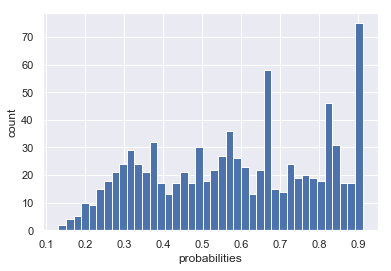

In [86]:
# Distribution of Model Performance
sns.set()
_ = plt.hist(dataf["PROBABILITY"], bins=bin_edges2)
_ = plt.xlabel("probabilities")
_ = plt.ylabel("count")
plt.show()